In [1]:

import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from src.data.dataset import PatchFromH5Dataset, stratified_split, plot_class_distributions
from src.rl.train import ModelTrainer, TrainingArguments
from src.rl.modelling import ViT_UCB_Pruning


/home/vcivale/UNI_UCB2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMG_SIZE = 224
TRAIN_BATCH_SIZE = 8
NUM_EPOCHS = 50

PRUNING_RATIO = 0.01

DEVICE = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
dataset = PatchFromH5Dataset(
    h5_dir='/equilibrium/datasets/TCGA-histological-data/hest/patches/patches/',
    transform=transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),])
)

In [4]:
# labels = dataset.labels

In [5]:
# # Crea un DataFrame con indici e label
# df = pd.DataFrame({
#     "index": np.arange(len(labels)),
#     "label": labels
# })

# # Trova il numero di elementi della classe minoritaria
# min_count = df["label"].value_counts().min()

# # Per ogni classe, seleziona min_count elementi a caso
# undersampled_df = (
#     df.groupby("label", group_keys=False)
#       .apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)
# )

# # Mischia gli indici
# undersampled_indices = undersampled_df["index"].sample(frac=1, random_state=42).tolist()


In [6]:
# undersampled_labels = [labels[i] for i in undersampled_indices]

trainval_idx, test_idx = train_test_split(
    list(range(len(dataset))),
    test_size=0.3,
    stratify=dataset.labels,
    random_state=42
)

# Ottieni i label corrispondenti per il secondo split
trainval_labels = [dataset.labels[i] for i in trainval_idx]

# Split: train vs val
train_idx, val_idx = train_test_split(
    trainval_idx,
    test_size=0.3,
    stratify=trainval_labels,
    random_state=42
)

# Crea i subset
train_dataset = Subset(dataset, train_idx)
val_dataset   = Subset(dataset, val_idx)
test_dataset  = Subset(dataset, test_idx)

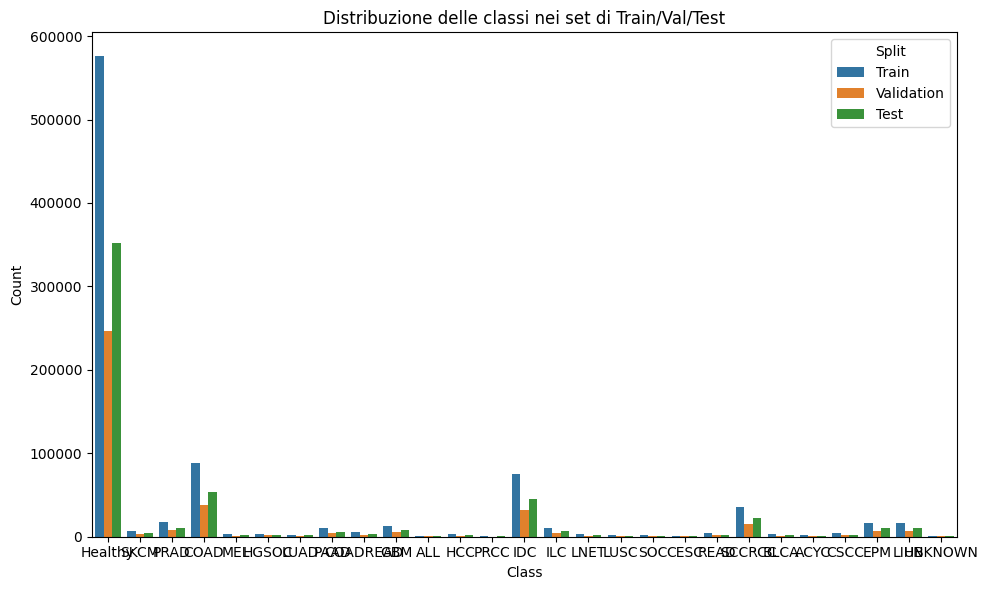

In [7]:
plot_class_distributions(train_dataset, val_dataset, test_dataset, full_dataset=dataset)

In [9]:
from torch.utils.data import WeightedRandomSampler

def make_sampler(subset):
    labels_subset = [dataset.labels[i] for i in subset.indices]
    class_sample_count = np.bincount(labels_subset)
    weights = 1.0 / class_sample_count[labels_subset]
    return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_sampler = make_sampler(train_dataset)
val_sampler   = make_sampler(val_dataset)
test_sampler  = make_sampler(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,  num_workers=16, drop_last=True, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=TRAIN_BATCH_SIZE,  num_workers=16, drop_last=True, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=16, drop_last=True, sampler=test_sampler)

In [10]:
labels_num = len(np.unique(dataset.labels))

print(f"Number of classes: {labels_num}")
model = ViT_UCB_Pruning(model_name="hf-hub:MahmoodLab/uni", 
    pretrained=True, 
    n_classes=labels_num, 
    keep_ratio=PRUNING_RATIO,        
    exclude_cls=False
)

Number of classes: 27
Loading source model 'hf-hub:MahmoodLab/uni'...


08/27/2025 10:53:38 - INFO - timm.models._builder - Loading pretrained weights from Hugging Face hub (MahmoodLab/uni)


In [11]:
args = TrainingArguments(
        output_dir="./results",
        run_name=f"ViT-L-UCB-{PRUNING_RATIO}",
        num_train_epochs=NUM_EPOCHS,
        learning_rate=0.1,
        train_batch_size=8,
        eval_batch_size=8,
        max_steps=-1,
        warmup_steps=500,
        eval_steps=5000,
        save_steps=10000,
        logging_steps=300,
        fp16=False,
        report_to="wandb", 
        early_stopping_patience=7, 
        early_stopping_metric="eval/loss", # Oppure monitora la loss (un valore più basso è meglio)
    )


In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
# The scheduler needs max_steps, so we calculate it first
num_steps = args.num_train_epochs * (len(train_loader) // args.gradient_accumulation_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=num_steps)

In [13]:
trainer = ModelTrainer(
        model=model,
        args=args,
        train_dataloader=train_loader,
        eval_dataloader=val_loader,
        test_dataloader=test_loader,
        class_names=dataset.class_names,           # Pass the class names
        optimizers=(optimizer, scheduler),
        device= DEVICE
    )

/home/vcivale/UNI_UCB2/src/rl/train.py:92: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler(enabled=self.args.fp16)
wandb: Currently logged in as: vincenzo-civale (vincenzo-civale-universi-degli-studi-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


08/27/2025 10:53:43 - INFO - src.rl.train - Early stopping enabled: monitoring 'eval/loss' with patience 7 and threshold 0.0001.


In [ ]:
trainer.train()

08/27/2025 10:53:43 - INFO - src.rl.train - ***** Running training *****
08/27/2025 10:53:43 - INFO - src.rl.train -   Num Epochs = 50
08/27/2025 10:53:43 - INFO - src.rl.train -   Total optimization steps = 5659900
Epoch 1/50:   0%|          | 0/113198 [00:00<?, ?it/s]/home/vcivale/UNI_UCB2/src/rl/train.py:213: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.fp16):
Epoch 1/50:   4%|▍         | 4999/113198 [33:49<12:00:30,  2.50it/s, loss=0.7723, lr=1.00e-01]08/27/2025 11:27:33 - INFO - src.rl.train - ***** Running Evaluation at Step 5000 *****
/home/vcivale/UNI_UCB2/src/rl/train.py:232: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=self.args.fp16):
